In [1]:
import numpy as np
import torch
import pyepo


# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.84it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.26it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.07it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 200
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch    9, Loss:  26.9536:   5%|██▋                                                  | 10/200 [00:13<03:18,  1.04s/it]

Epoch  10, Train Regret:  26.5598%, Val Regret:  27.9583%


Epoch   19, Loss:  18.8505:  10%|█████▎                                               | 20/200 [00:25<03:06,  1.04s/it]

Epoch  20, Train Regret:  22.3607%, Val Regret:  24.4209%


Epoch   29, Loss:  12.4331:  15%|███████▉                                             | 30/200 [00:37<02:56,  1.04s/it]

Epoch  30, Train Regret:  22.1711%, Val Regret:  23.2998%


Epoch   39, Loss:   7.5962:  20%|██████████▌                                          | 40/200 [00:49<02:46,  1.04s/it]

Epoch  40, Train Regret:  20.5114%, Val Regret:  20.8483%


Epoch   49, Loss:  11.2209:  25%|█████████████▎                                       | 50/200 [01:01<02:36,  1.04s/it]

Epoch  50, Train Regret:  18.2436%, Val Regret:  18.6697%


Epoch   59, Loss:   6.6272:  30%|███████████████▉                                     | 60/200 [01:13<02:25,  1.04s/it]

Epoch  60, Train Regret:  17.1757%, Val Regret:  18.0560%


Epoch   69, Loss:   5.5917:  35%|██████████████████▌                                  | 70/200 [01:25<02:14,  1.04s/it]

Epoch  70, Train Regret:  16.4065%, Val Regret:  17.8589%


Epoch   79, Loss:   8.0900:  40%|█████████████████████▏                               | 80/200 [01:37<02:04,  1.04s/it]

Epoch  80, Train Regret:  16.5689%, Val Regret:  17.1760%


Epoch   89, Loss:   4.9189:  45%|███████████████████████▊                             | 90/200 [01:49<01:54,  1.04s/it]

Epoch  90, Train Regret:  16.7718%, Val Regret:  17.3690%


Epoch   99, Loss:   9.0128:  50%|██████████████████████████                          | 100/200 [02:00<01:43,  1.04s/it]

Epoch 100, Train Regret:  16.2603%, Val Regret:  16.4020%


Epoch  109, Loss:   6.0729:  55%|████████████████████████████▌                       | 110/200 [02:12<01:33,  1.04s/it]

Epoch 110, Train Regret:  15.6664%, Val Regret:  17.0725%


Epoch  119, Loss:  13.3693:  60%|███████████████████████████████▏                    | 120/200 [02:24<01:23,  1.04s/it]

Epoch 120, Train Regret:  15.5406%, Val Regret:  16.2942%


Epoch  129, Loss:   5.4347:  65%|█████████████████████████████████▊                  | 130/200 [02:36<01:12,  1.04s/it]

Epoch 130, Train Regret:  15.7107%, Val Regret:  16.2797%


Epoch  139, Loss:   7.0661:  70%|████████████████████████████████████▍               | 140/200 [02:48<01:02,  1.04s/it]

Epoch 140, Train Regret:  14.9283%, Val Regret:  15.9984%


Epoch  149, Loss:  11.8526:  75%|███████████████████████████████████████             | 150/200 [03:00<00:52,  1.04s/it]

Epoch 150, Train Regret:  15.3930%, Val Regret:  15.5564%


Epoch  159, Loss:  17.3737:  80%|█████████████████████████████████████████▌          | 160/200 [03:12<00:41,  1.04s/it]

Epoch 160, Train Regret:  15.6317%, Val Regret:  16.1771%


Epoch  169, Loss:   7.2706:  85%|████████████████████████████████████████████▏       | 170/200 [03:24<00:31,  1.04s/it]

Epoch 170, Train Regret:  15.8812%, Val Regret:  16.6635%


Epoch  179, Loss:   5.2855:  90%|██████████████████████████████████████████████▊     | 180/200 [03:36<00:24,  1.20s/it]


Epoch 180, Train Regret:  14.4521%, Val Regret:  16.5971%

Early Stop!

Evaluation:
Test Regret: 16.9990%
Training Elapsed Time: 1.78 Sec


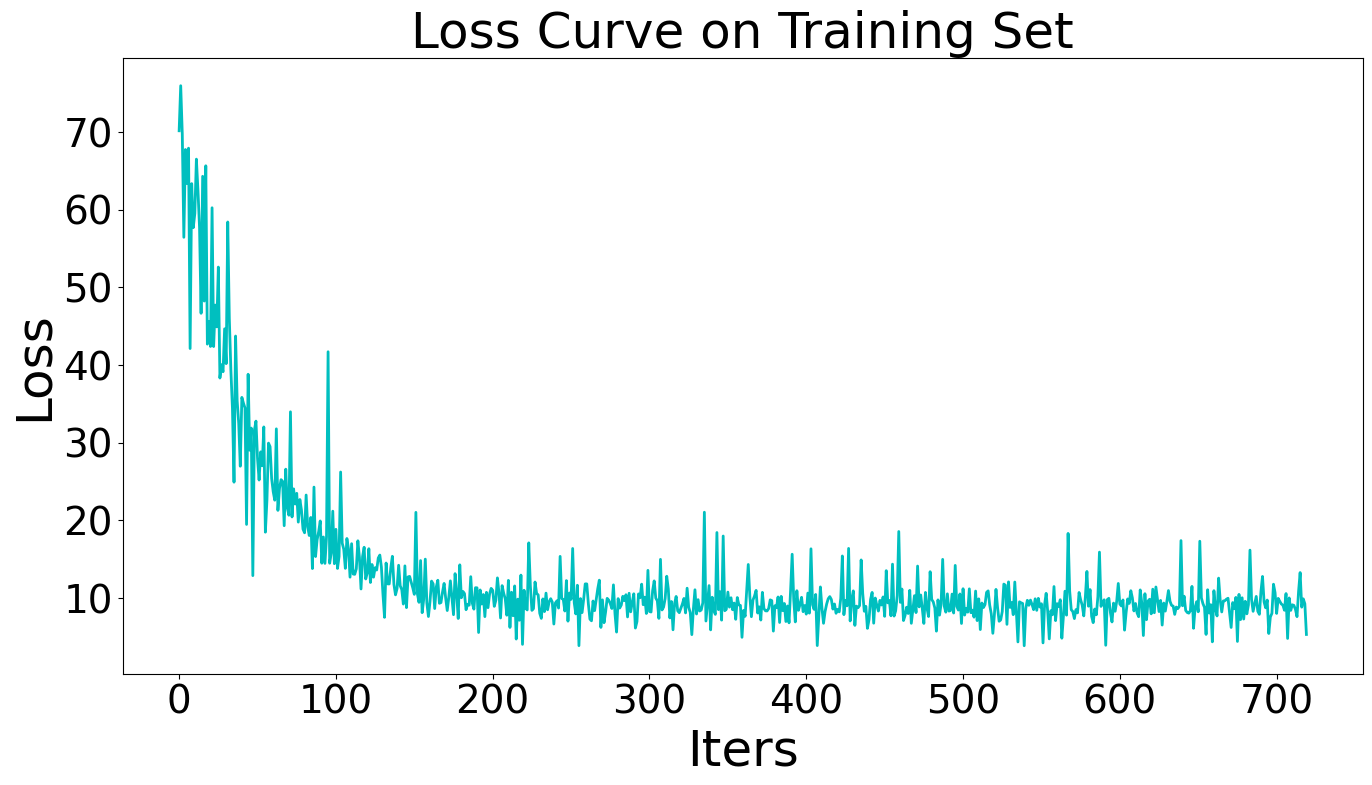

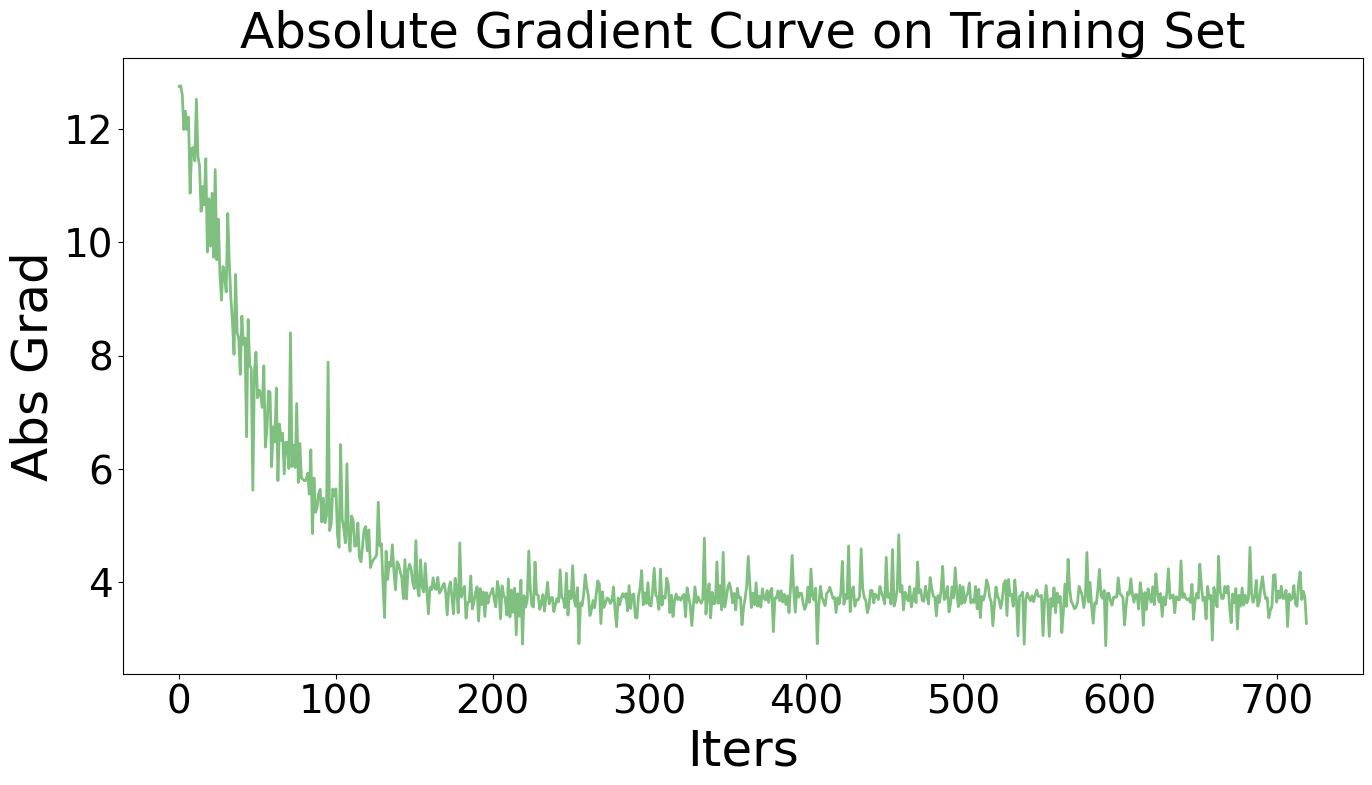

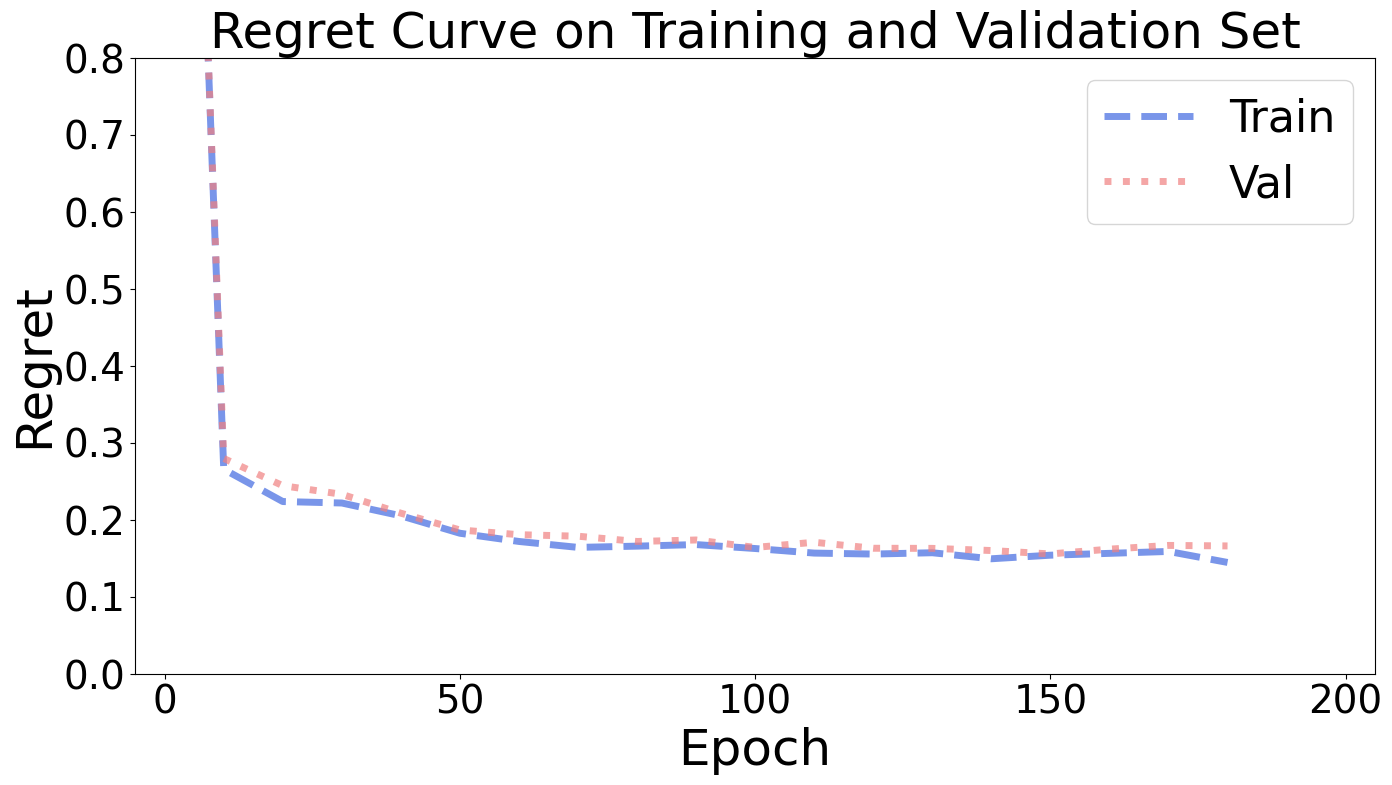

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 199.3609%, Val Regret: 185.2989%


Epoch    9, Loss:  -0.9992:   5%|██▋                                                  | 10/200 [00:19<04:09,  1.31s/it]

Epoch  10, Train Regret:  17.2838%, Val Regret:  36.0602%


Epoch   19, Loss:  -0.9999:  10%|█████▎                                               | 20/200 [00:33<03:47,  1.26s/it]

Epoch  20, Train Regret:  11.8809%, Val Regret:  29.1055%


Epoch   29, Loss:  -1.0000:  15%|███████▉                                             | 30/200 [00:47<03:35,  1.27s/it]

Epoch  30, Train Regret:   7.6465%, Val Regret:  28.3284%


Epoch   39, Loss:  -1.0000:  20%|██████████▌                                          | 40/200 [01:01<03:22,  1.26s/it]

Epoch  40, Train Regret:   7.8933%, Val Regret:  28.2447%


Epoch   49, Loss:  -1.0000:  25%|█████████████▎                                       | 50/200 [01:15<03:09,  1.26s/it]

Epoch  50, Train Regret:   5.1548%, Val Regret:  28.0116%


Epoch   59, Loss:  -1.0000:  30%|███████████████▉                                     | 60/200 [01:29<02:56,  1.26s/it]

Epoch  60, Train Regret:   5.1746%, Val Regret:  28.3400%


Epoch   69, Loss:  -1.0000:  35%|██████████████████▌                                  | 70/200 [01:43<02:44,  1.27s/it]

Epoch  70, Train Regret:   3.2564%, Val Regret:  28.2837%


Epoch   79, Loss:  -1.0000:  40%|█████████████████████▏                               | 80/200 [01:57<02:56,  1.47s/it]


Epoch  80, Train Regret:   1.7717%, Val Regret:  28.2837%

Early Stop!

Evaluation:
Test Regret: 27.6989%
Training Elapsed Time: 23.16 Sec


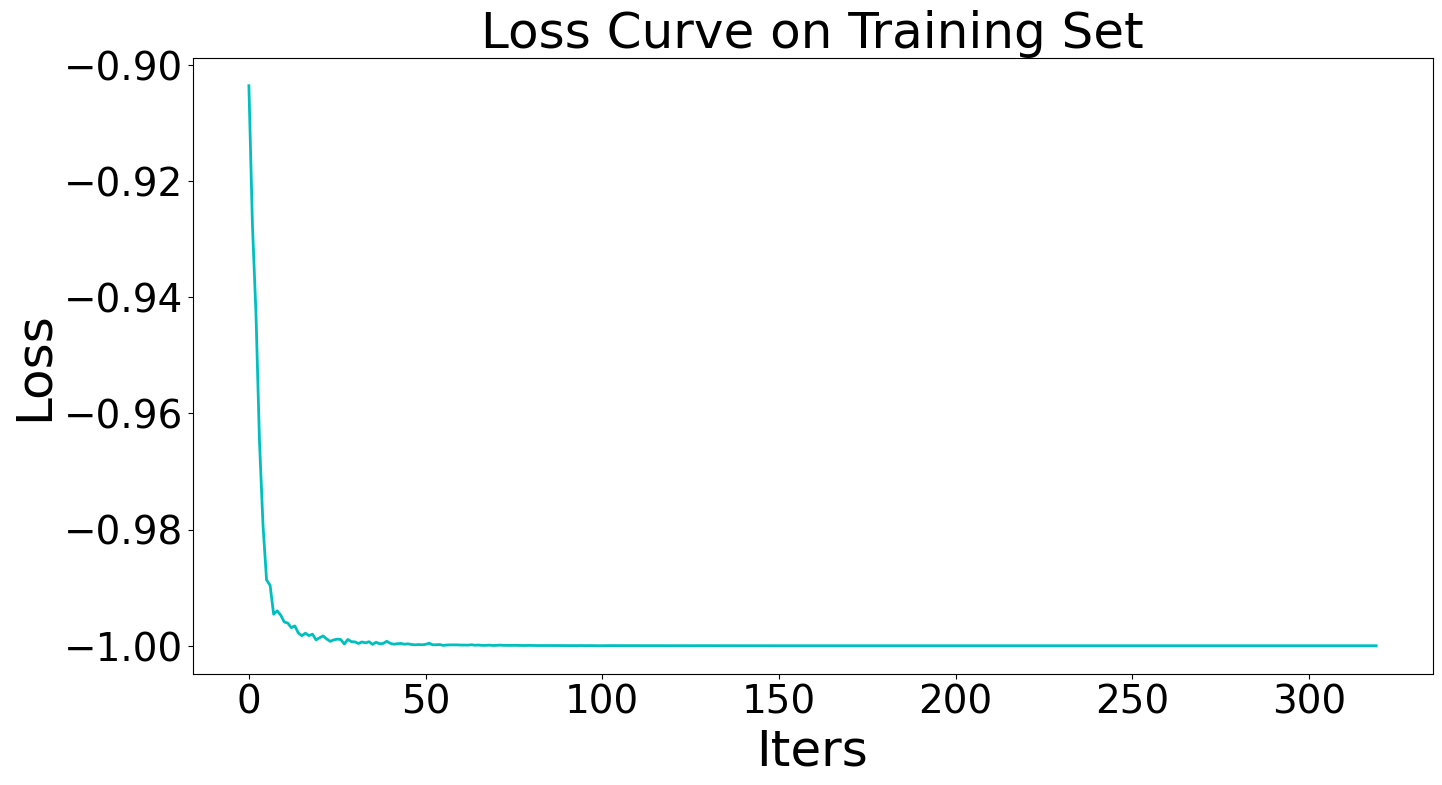

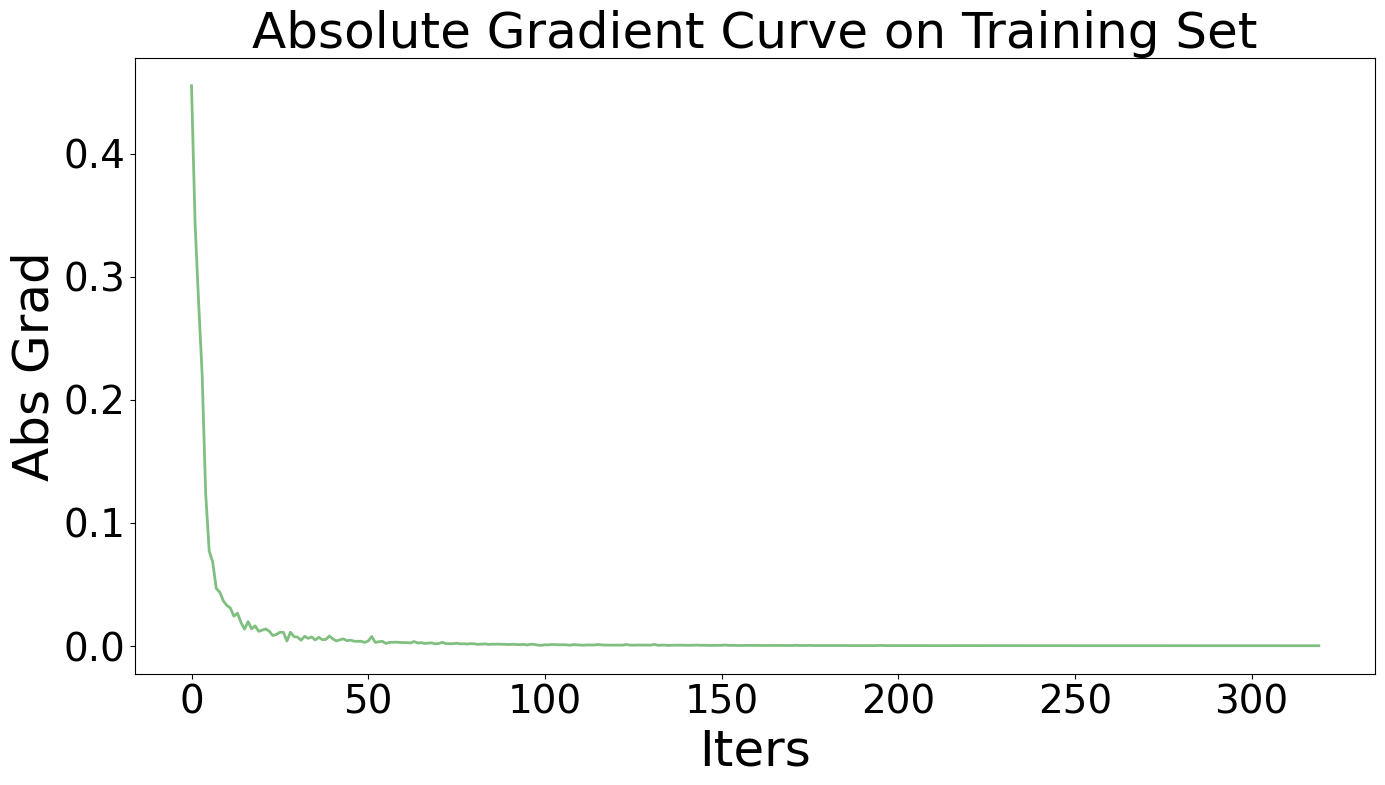

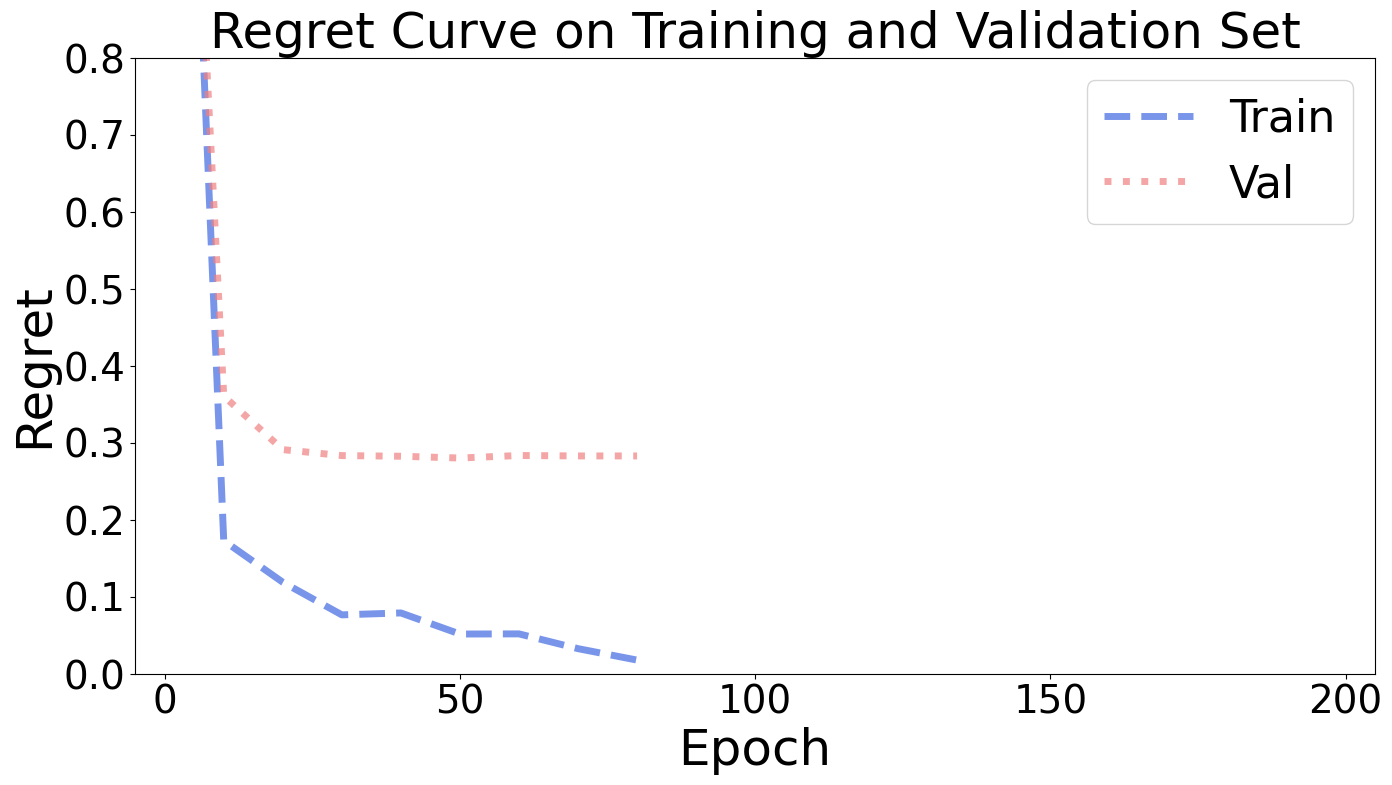

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 201.6135%, Val Regret: 198.7642%


Epoch    9, Loss:  -0.9995:   5%|██▋                                                  | 10/200 [00:15<03:59,  1.26s/it]

Epoch  10, Train Regret:  16.7255%, Val Regret:  35.8760%


Epoch   19, Loss:  -0.9999:  10%|█████▎                                               | 20/200 [00:29<03:47,  1.26s/it]

Epoch  20, Train Regret:  10.3028%, Val Regret:  29.4578%


Epoch   29, Loss:  -1.0000:  15%|███████▉                                             | 30/200 [00:43<03:34,  1.26s/it]

Epoch  30, Train Regret:   9.8644%, Val Regret:  29.0598%


Epoch   39, Loss:  -1.0000:  20%|██████████▌                                          | 40/200 [00:57<03:22,  1.27s/it]

Epoch  40, Train Regret:   7.7597%, Val Regret:  28.6782%


Epoch   49, Loss:  -1.0000:  25%|█████████████▎                                       | 50/200 [01:11<03:11,  1.28s/it]

Epoch  50, Train Regret:   7.0941%, Val Regret:  26.1758%


Epoch   59, Loss:  -1.0000:  30%|███████████████▉                                     | 60/200 [01:25<02:58,  1.28s/it]

Epoch  60, Train Regret:   6.0222%, Val Regret:  27.4192%


Epoch   69, Loss:  -1.0000:  35%|██████████████████▌                                  | 70/200 [01:40<02:45,  1.27s/it]

Epoch  70, Train Regret:   4.7907%, Val Regret:  27.2650%


Epoch   79, Loss:  -1.0000:  40%|█████████████████████▏                               | 80/200 [01:54<02:52,  1.43s/it]


Epoch  80, Train Regret:   3.4478%, Val Regret:  27.2271%

Early Stop!

Evaluation:
Test Regret: 27.6177%
Training Elapsed Time: 19.49 Sec


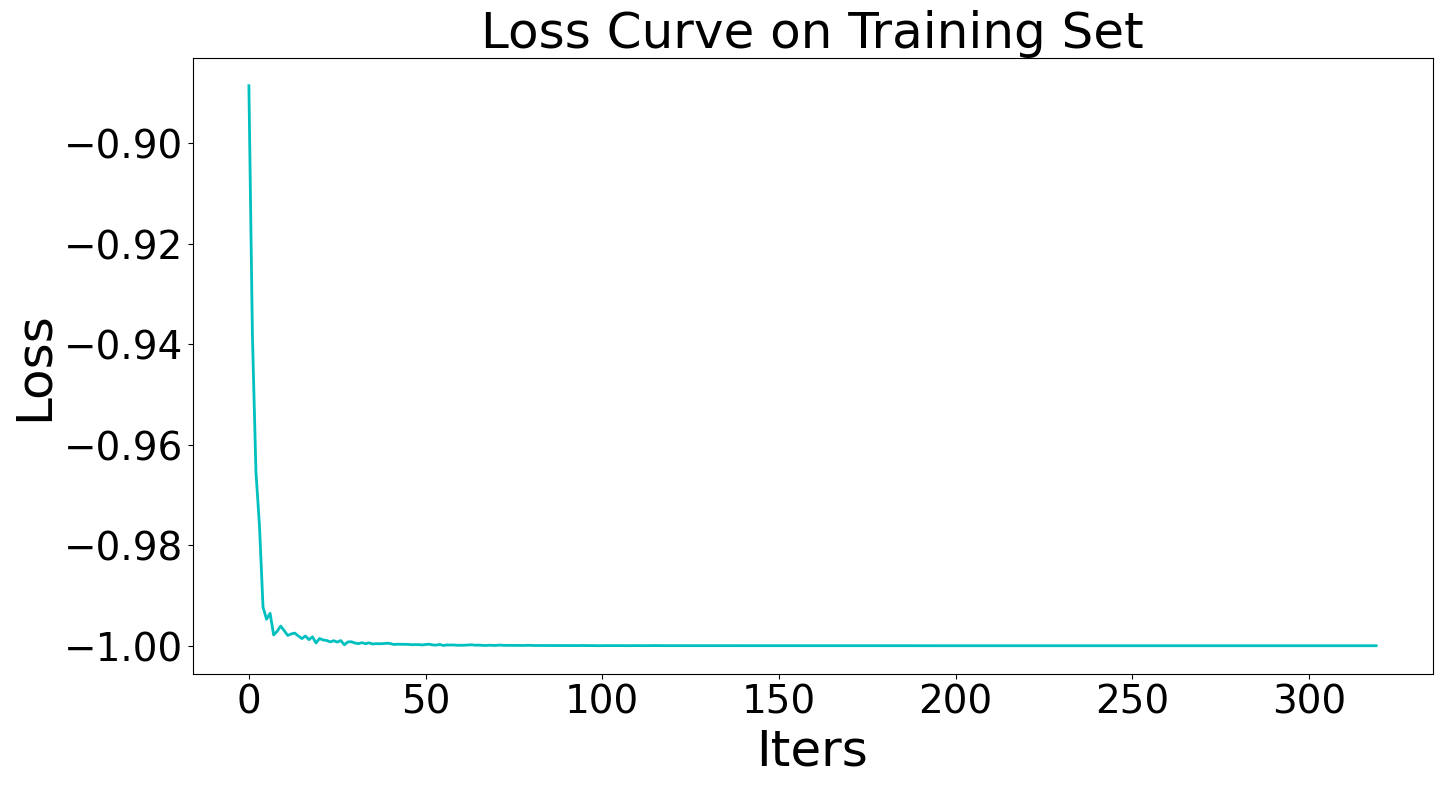

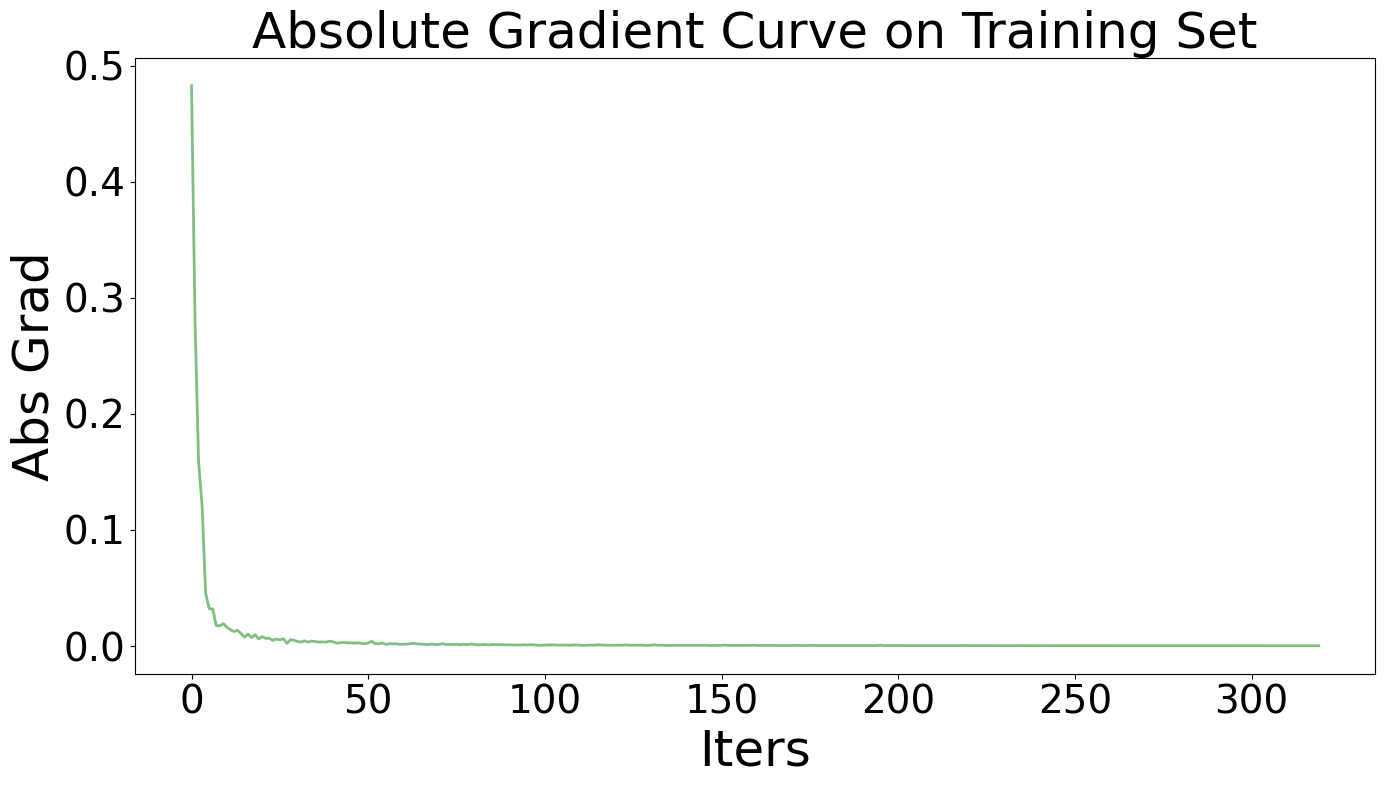

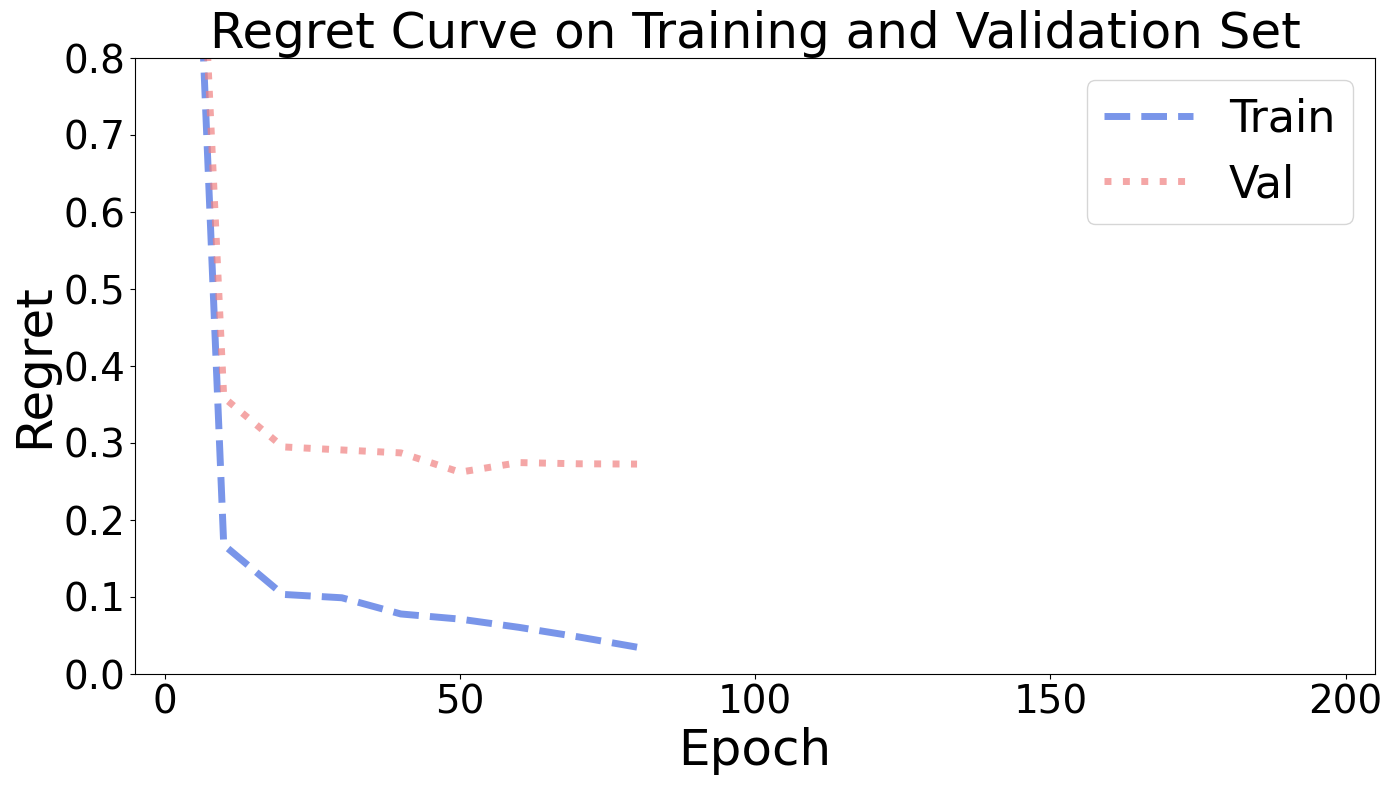

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 201.6135%, Val Regret: 198.7642%


Epoch    9, Loss:  -0.7069:   5%|██▋                                                  | 10/200 [00:14<03:42,  1.17s/it]

Epoch  10, Train Regret:  17.3337%, Val Regret:  27.3151%


Epoch   19, Loss:  -0.7712:  10%|█████▎                                               | 20/200 [00:28<03:29,  1.16s/it]

Epoch  20, Train Regret:  17.2326%, Val Regret:  24.8101%


Epoch   29, Loss:  -0.7548:  15%|███████▉                                             | 30/200 [00:41<03:15,  1.15s/it]

Epoch  30, Train Regret:  15.1593%, Val Regret:  21.3289%


Epoch   39, Loss:  -0.8055:  20%|██████████▌                                          | 40/200 [00:54<03:02,  1.14s/it]

Epoch  40, Train Regret:  16.5796%, Val Regret:  26.3126%


Epoch   49, Loss:  -0.7265:  25%|█████████████▎                                       | 50/200 [01:07<02:50,  1.14s/it]

Epoch  50, Train Regret:  14.2056%, Val Regret:  22.5283%


Epoch   59, Loss:  -0.7400:  30%|███████████████▉                                     | 60/200 [01:20<03:07,  1.34s/it]


Epoch  60, Train Regret:  15.7357%, Val Regret:  23.9111%

Early Stop!

Evaluation:
Test Regret: 24.0443%
Training Elapsed Time: 7.09 Sec


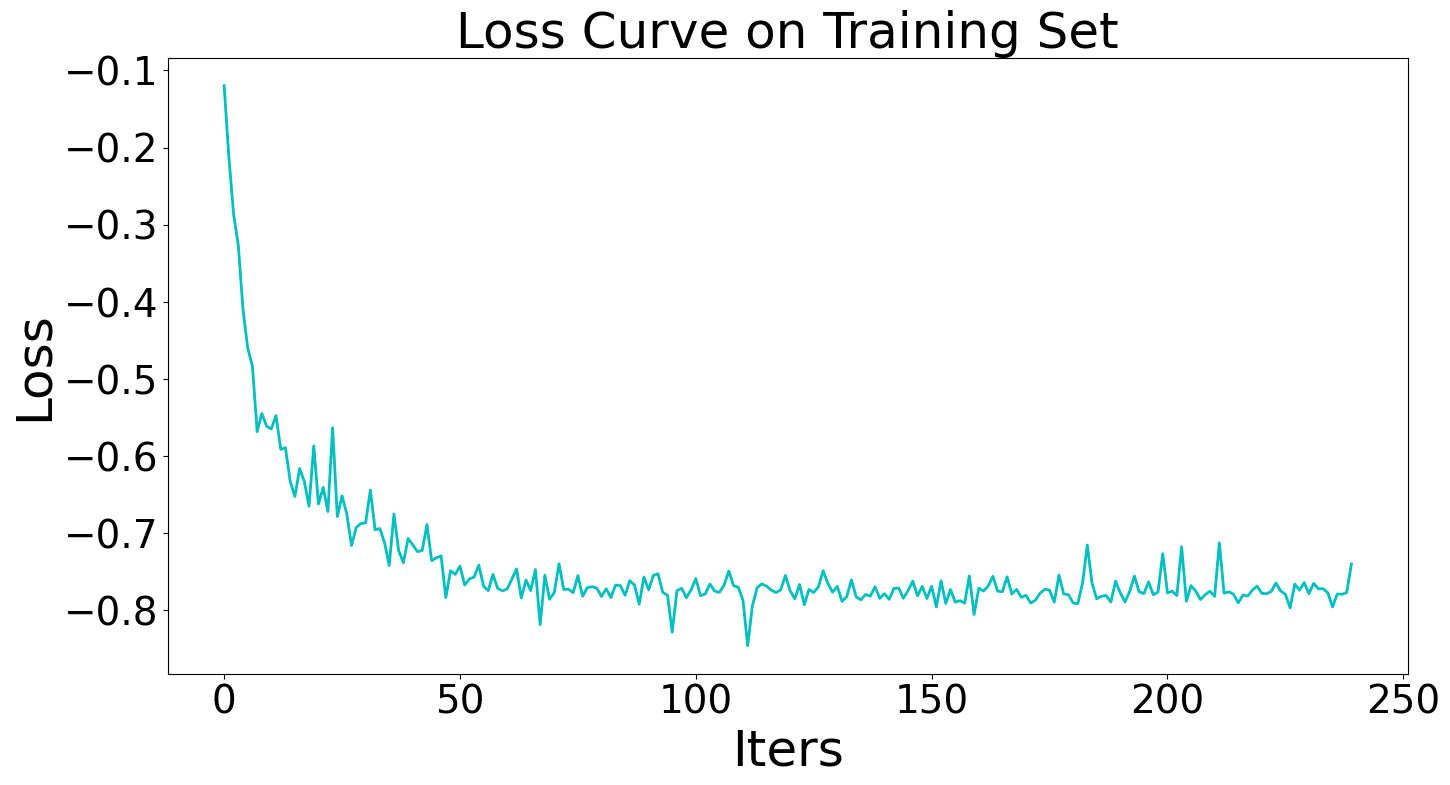

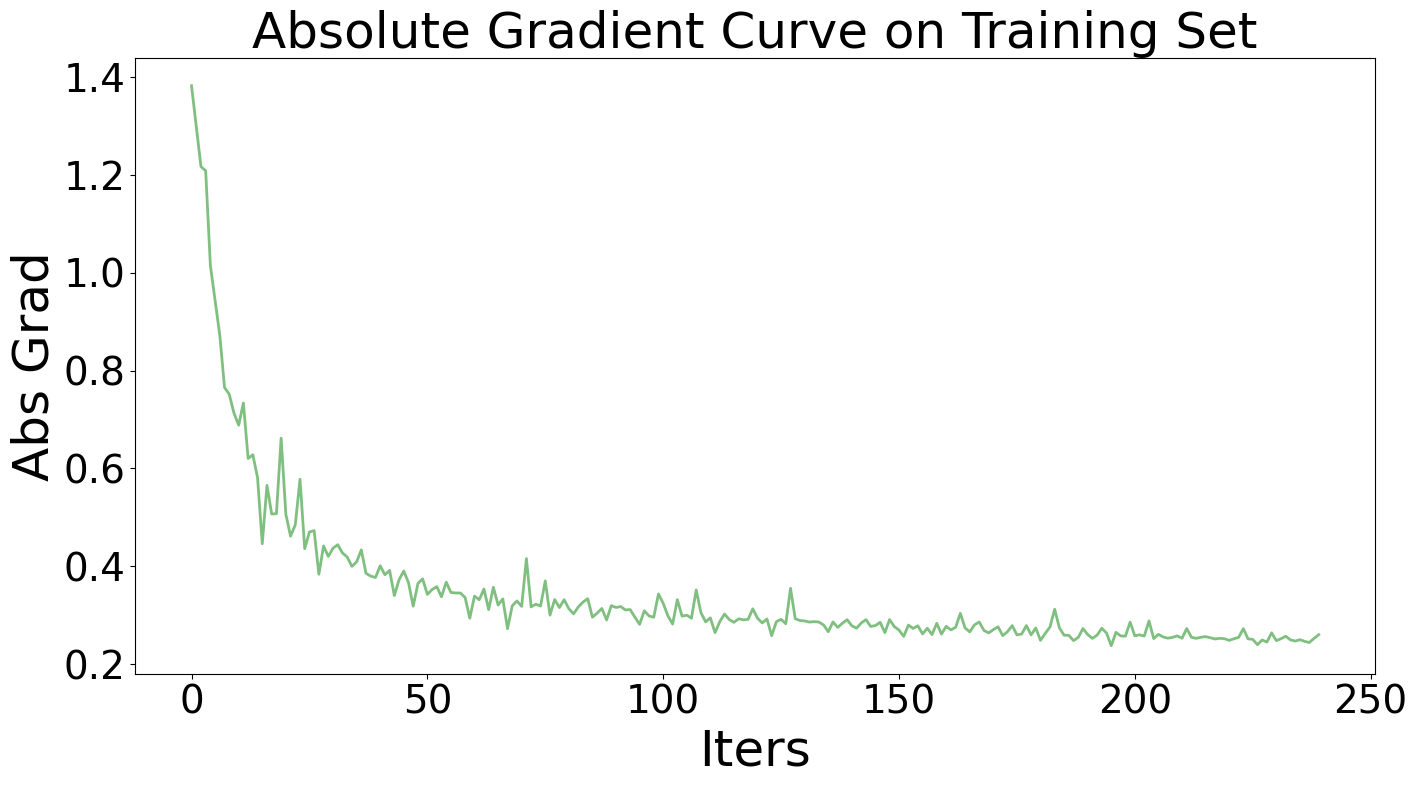

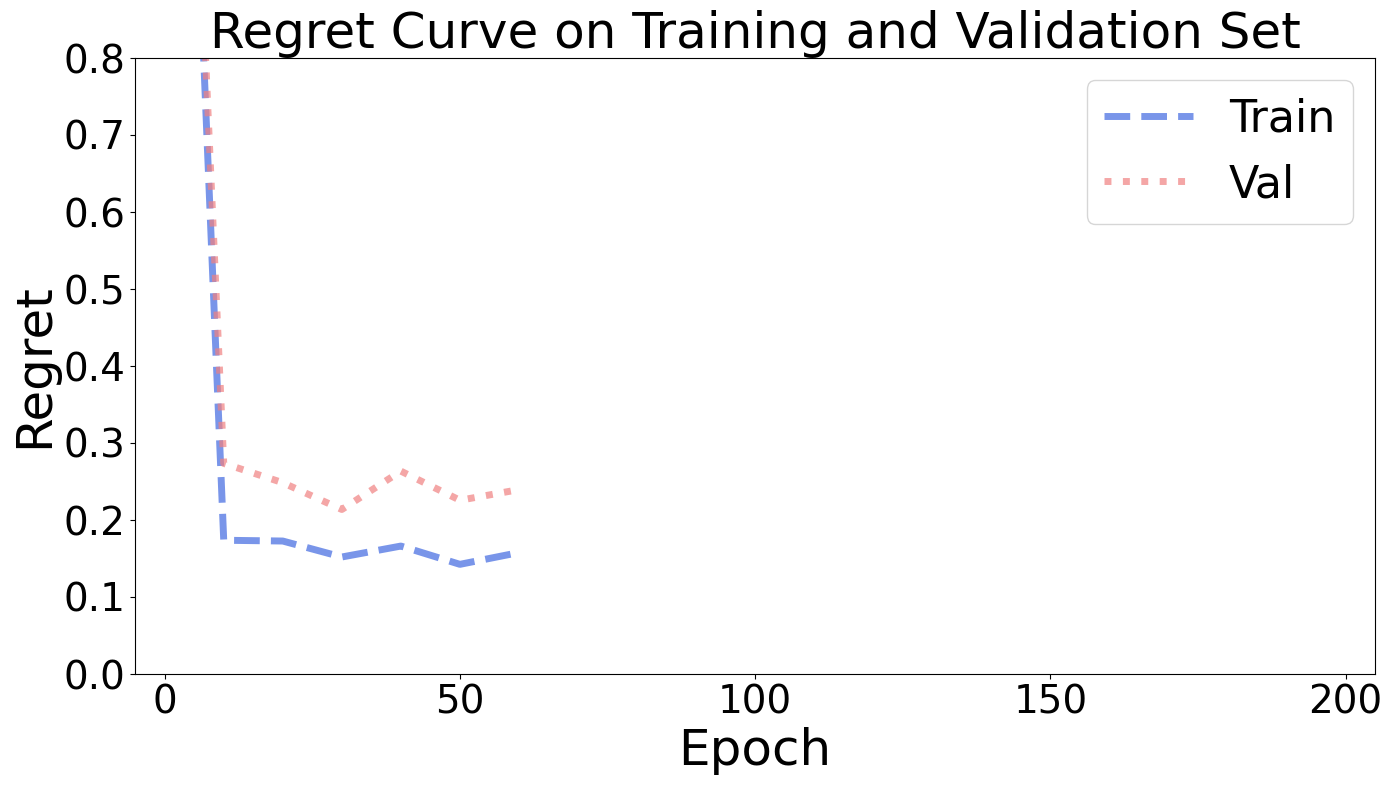

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 221.2056%, Val Regret: 210.8099%


Epoch    9, Loss:  -0.6296:   5%|██▋                                                  | 10/200 [00:13<03:20,  1.05s/it]

Epoch  10, Train Regret:  14.0691%, Val Regret:  21.7136%


Epoch   19, Loss:  -0.7305:  10%|█████▎                                               | 20/200 [00:26<03:09,  1.05s/it]

Epoch  20, Train Regret:  13.6569%, Val Regret:  23.3717%


Epoch   29, Loss:  -0.7716:  15%|███████▉                                             | 30/200 [00:38<02:58,  1.05s/it]

Epoch  30, Train Regret:  15.5899%, Val Regret:  23.4494%


Epoch   39, Loss:  -0.8307:  20%|██████████▌                                          | 40/200 [00:50<03:20,  1.26s/it]


Epoch  40, Train Regret:  14.3403%, Val Regret:  23.1094%

Early Stop!

Evaluation:
Test Regret: 23.8198%
Training Elapsed Time: 0.92 Sec


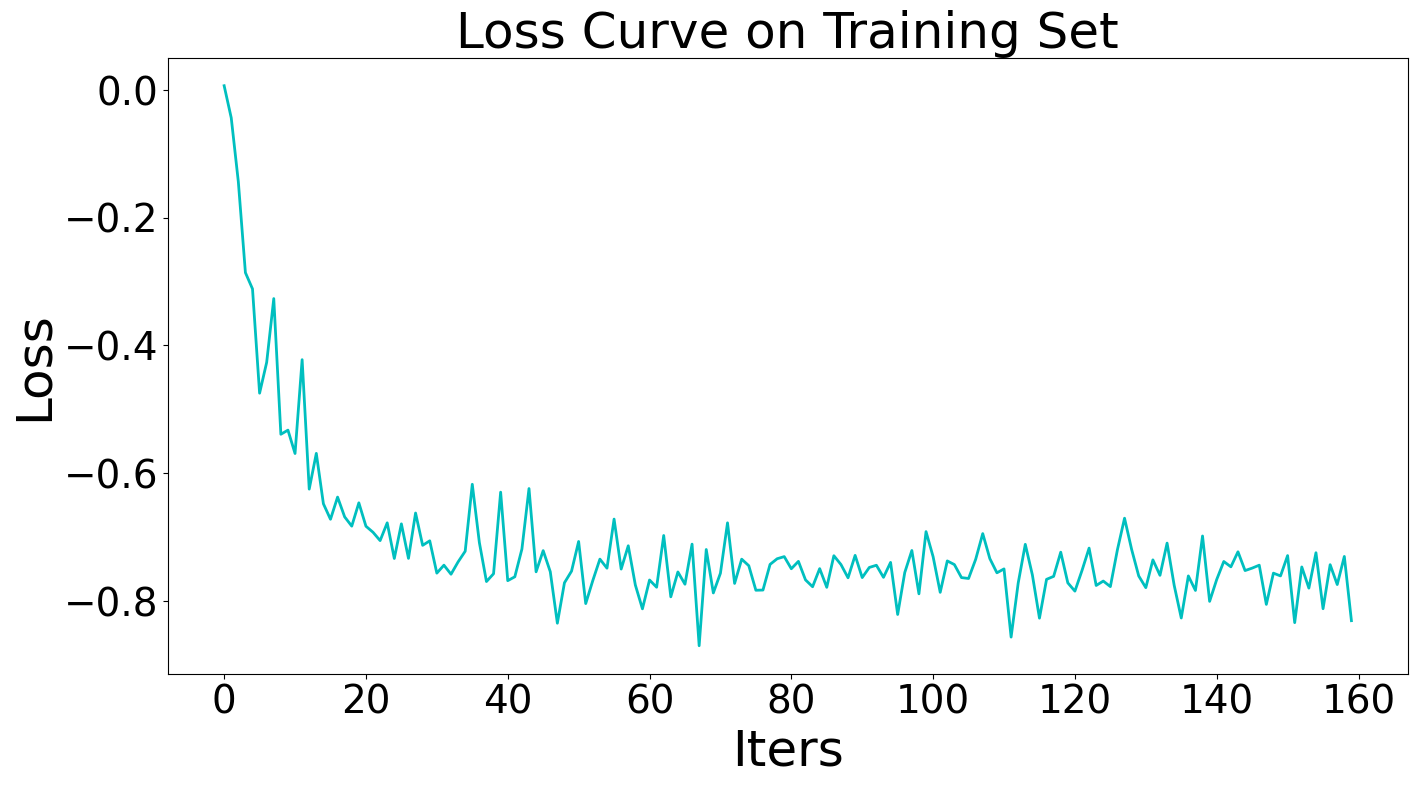

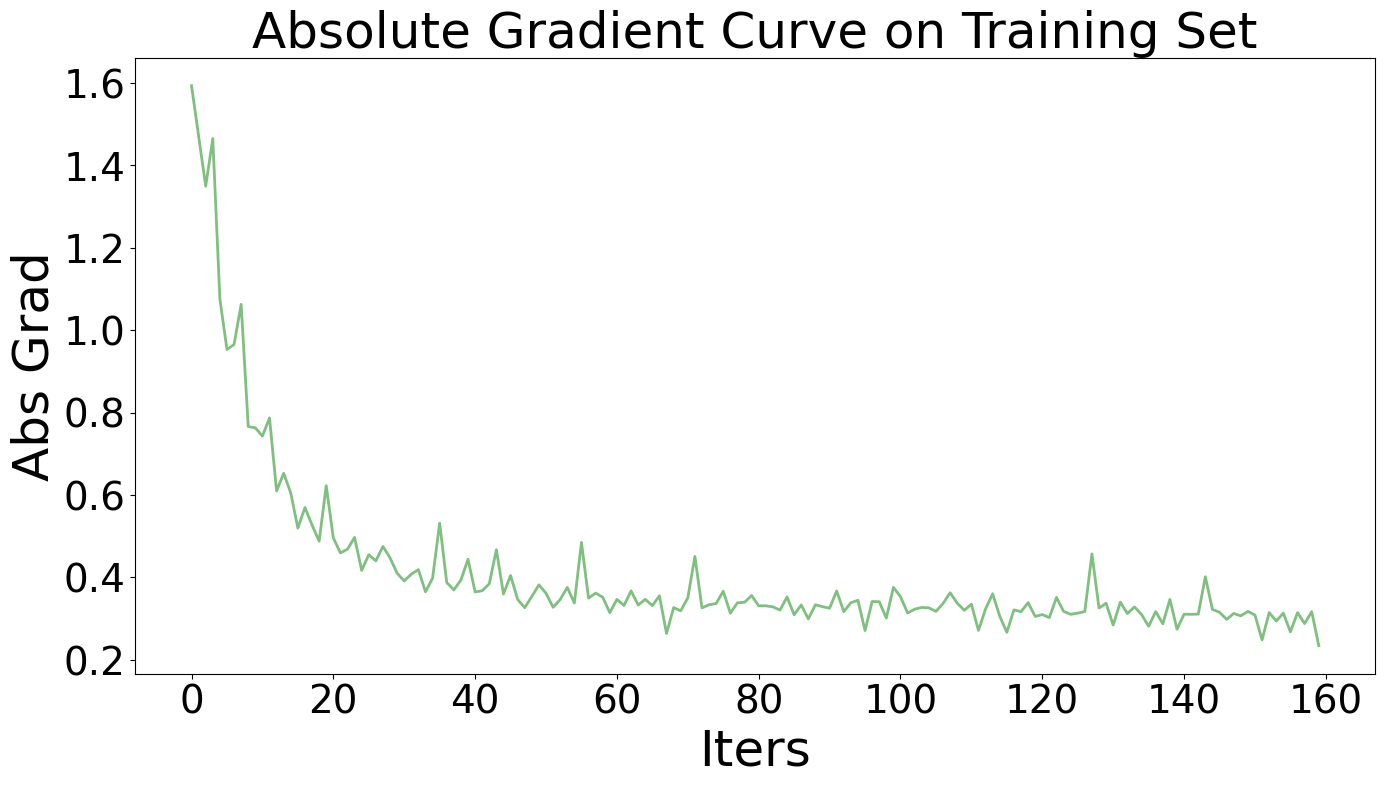

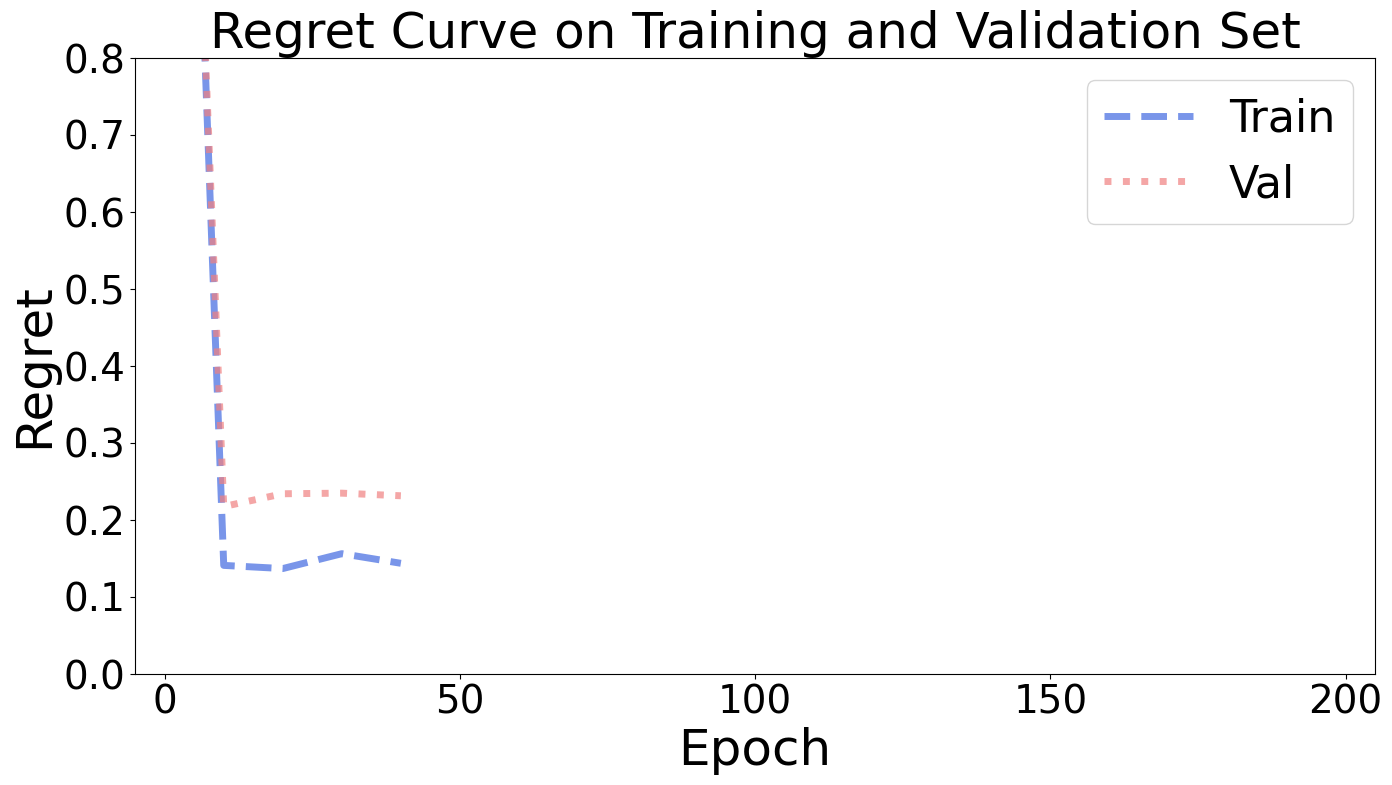

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [34]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 213.7139%, Val Regret: 206.0455%


Epoch    9, Loss:  20.5000:   5%|██▋                                                  | 10/200 [00:16<04:08,  1.31s/it]

Epoch  10, Train Regret:   9.8868%, Val Regret:  18.9429%


Epoch   19, Loss:  13.5000:  10%|█████▎                                               | 20/200 [00:30<03:53,  1.30s/it]

Epoch  20, Train Regret:   5.5965%, Val Regret:  16.9026%


Epoch   29, Loss:   8.0000:  15%|███████▉                                             | 30/200 [00:44<03:40,  1.30s/it]

Epoch  30, Train Regret:   5.0529%, Val Regret:  16.9583%


Epoch   39, Loss:  14.5000:  20%|██████████▌                                          | 40/200 [00:59<03:28,  1.30s/it]

Epoch  40, Train Regret:   5.1205%, Val Regret:  17.5558%


Epoch   49, Loss:   9.0000:  25%|█████████████▎                                       | 50/200 [01:14<03:42,  1.48s/it]


Epoch  50, Train Regret:   3.9133%, Val Regret:  17.1153%

Early Stop!

Evaluation:
Test Regret: 16.4692%
Training Elapsed Time: 14.36 Sec


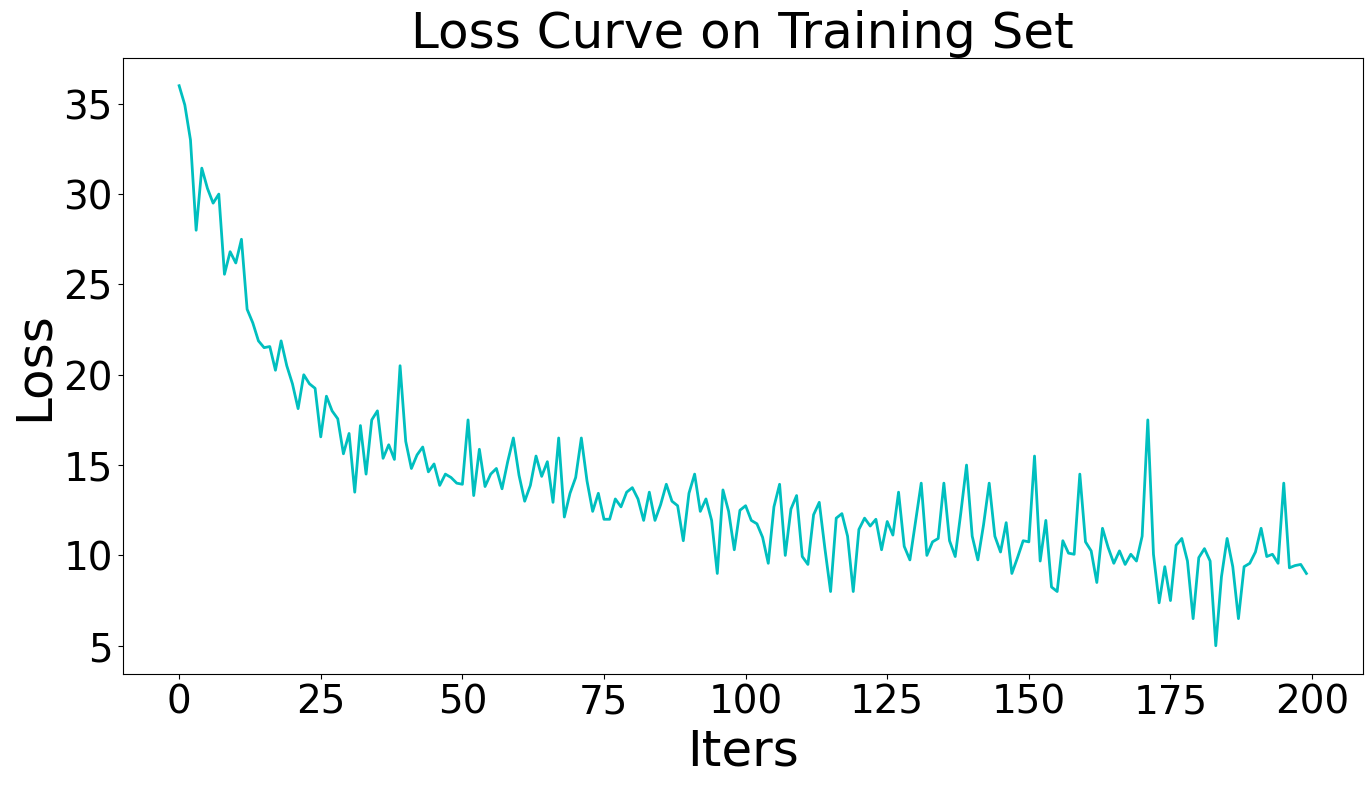

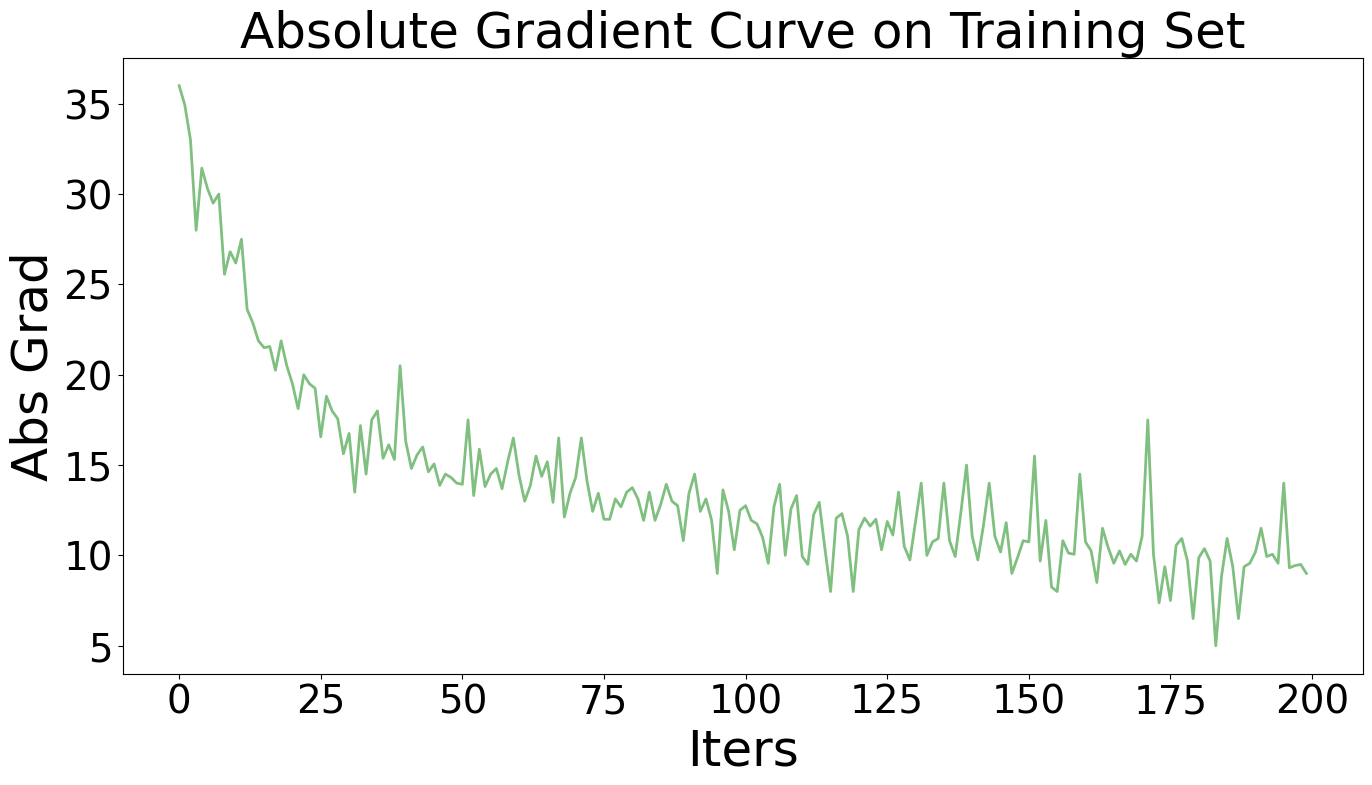

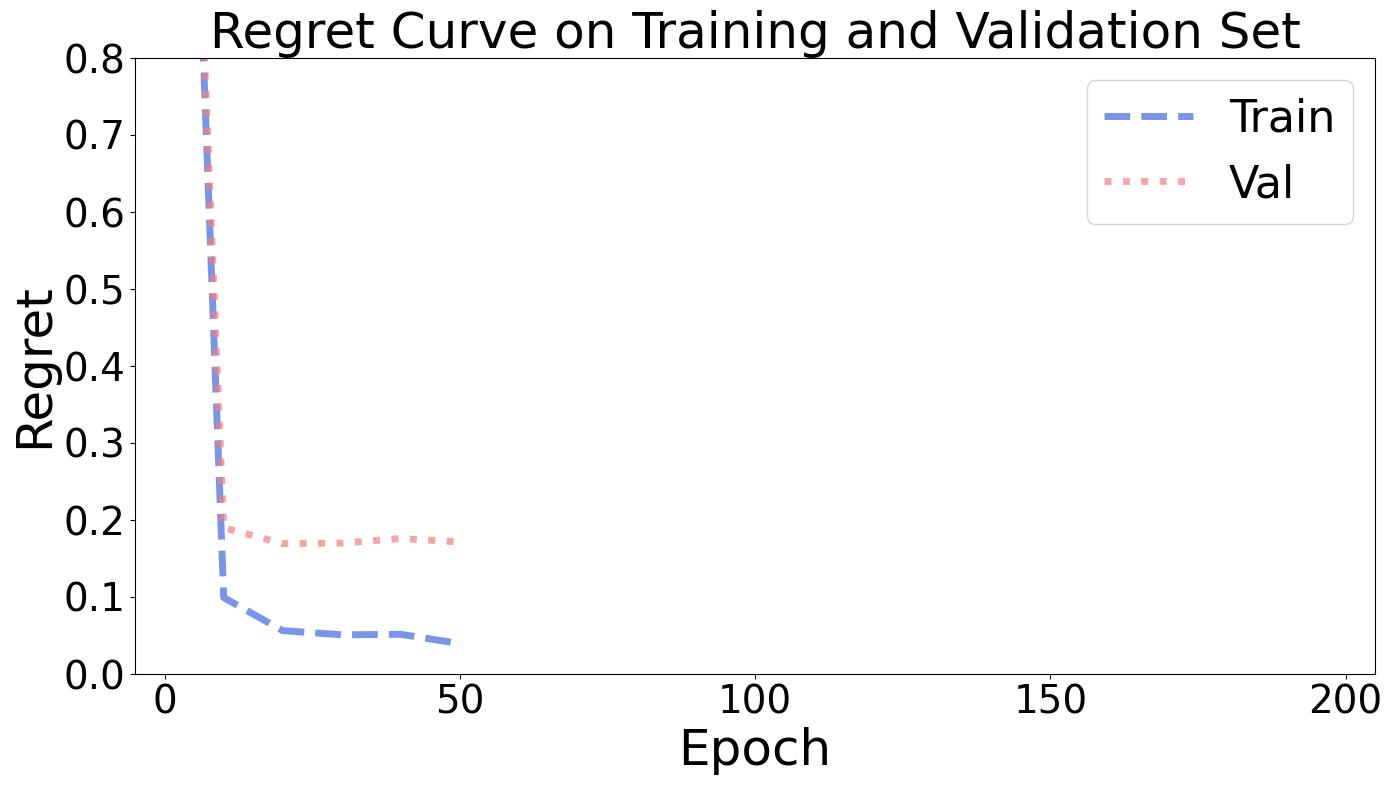

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 215.7061%, Val Regret: 206.8763%


Epoch    9, Loss: -80.1628:   5%|██▋                                                  | 10/200 [00:13<03:22,  1.06s/it]

Epoch  10, Train Regret:  23.5493%, Val Regret:  35.9652%


Epoch   19, Loss: -192.8902:  10%|█████▏                                              | 20/200 [00:26<03:13,  1.08s/it]

Epoch  20, Train Regret:  16.8962%, Val Regret:  30.3137%


Epoch   29, Loss: -331.5625:  15%|███████▊                                            | 30/200 [00:38<03:00,  1.06s/it]

Epoch  30, Train Regret:  16.7182%, Val Regret:  29.9130%


Epoch   39, Loss: -346.9013:  20%|██████████▍                                         | 40/200 [00:50<02:50,  1.06s/it]

Epoch  40, Train Regret:  16.0226%, Val Regret:  28.7417%


Epoch   49, Loss: -386.6991:  25%|█████████████                                       | 50/200 [01:02<02:37,  1.05s/it]

Epoch  50, Train Regret:  15.4145%, Val Regret:  28.5158%


Epoch   59, Loss: -594.8678:  30%|███████████████▌                                    | 60/200 [01:15<02:31,  1.08s/it]

Epoch  60, Train Regret:  16.6468%, Val Regret:  27.6915%


Epoch   69, Loss: -503.7655:  35%|██████████████████▏                                 | 70/200 [01:27<02:16,  1.05s/it]

Epoch  70, Train Regret:  15.8769%, Val Regret:  28.2672%


Epoch   79, Loss: -714.6327:  40%|████████████████████▊                               | 80/200 [01:39<02:08,  1.07s/it]

Epoch  80, Train Regret:  16.1750%, Val Regret:  28.1153%


Epoch   89, Loss: -703.1390:  45%|███████████████████████▍                            | 90/200 [01:52<02:16,  1.24s/it]


Epoch  90, Train Regret:  15.6982%, Val Regret:  27.8244%

Early Stop!

Evaluation:
Test Regret: 29.7164%
Training Elapsed Time: 3.73 Sec


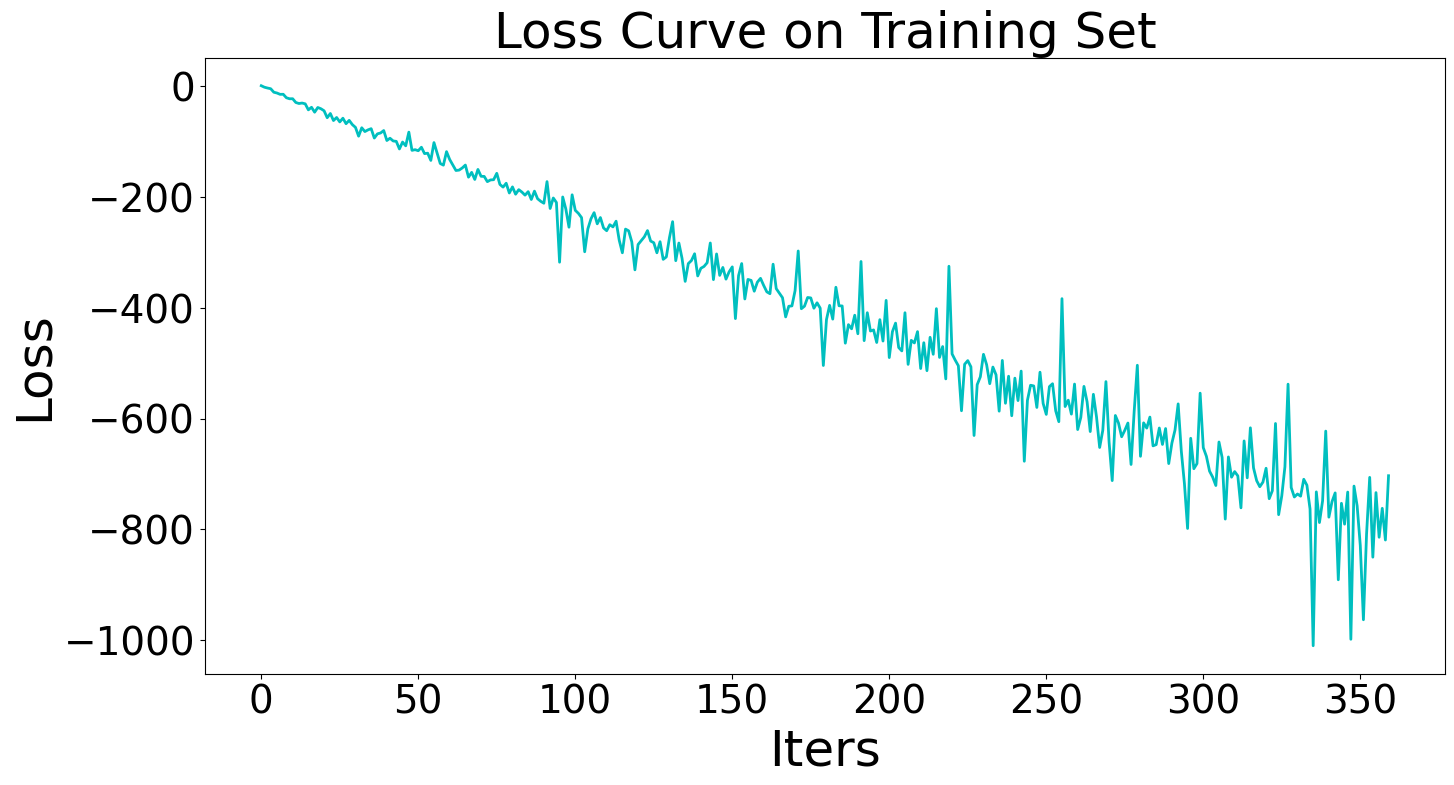

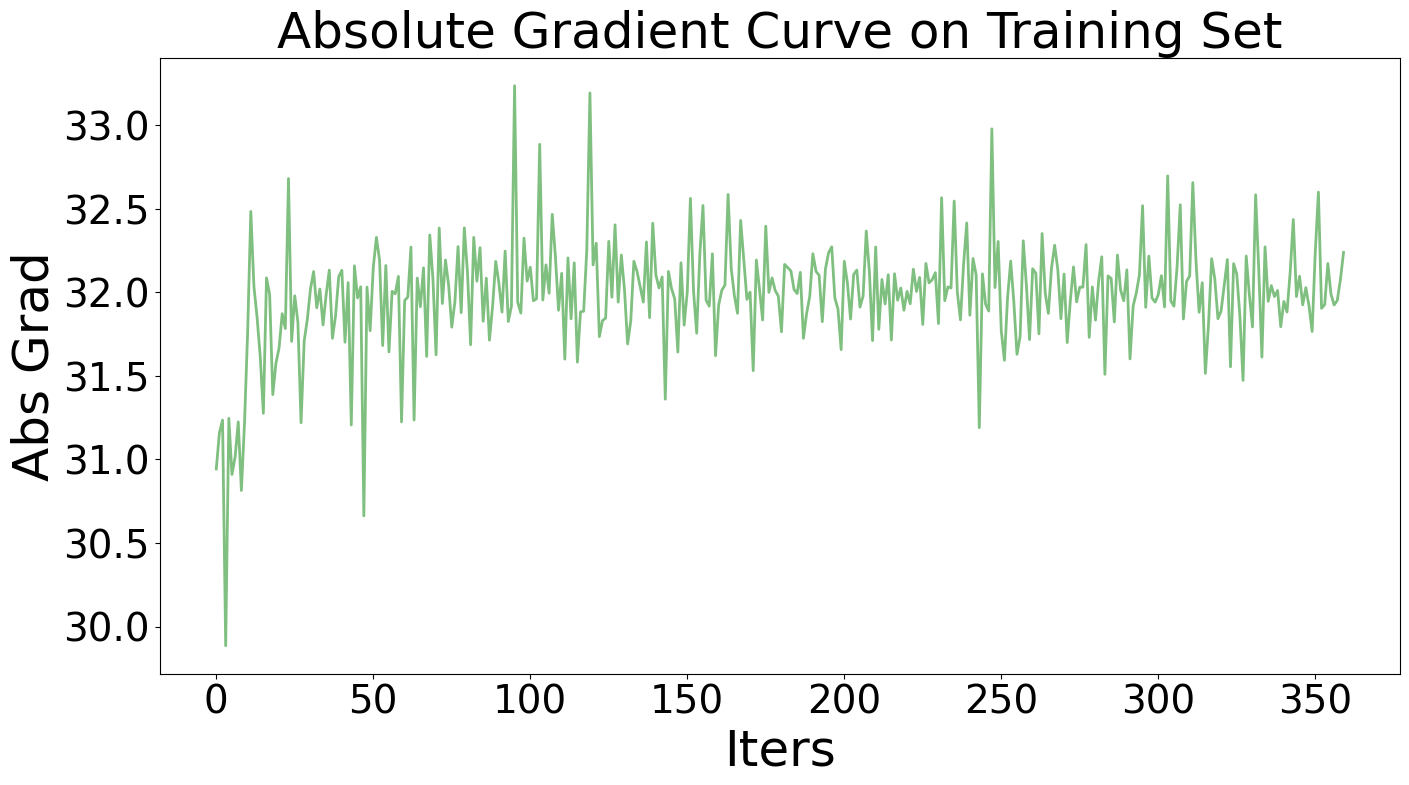

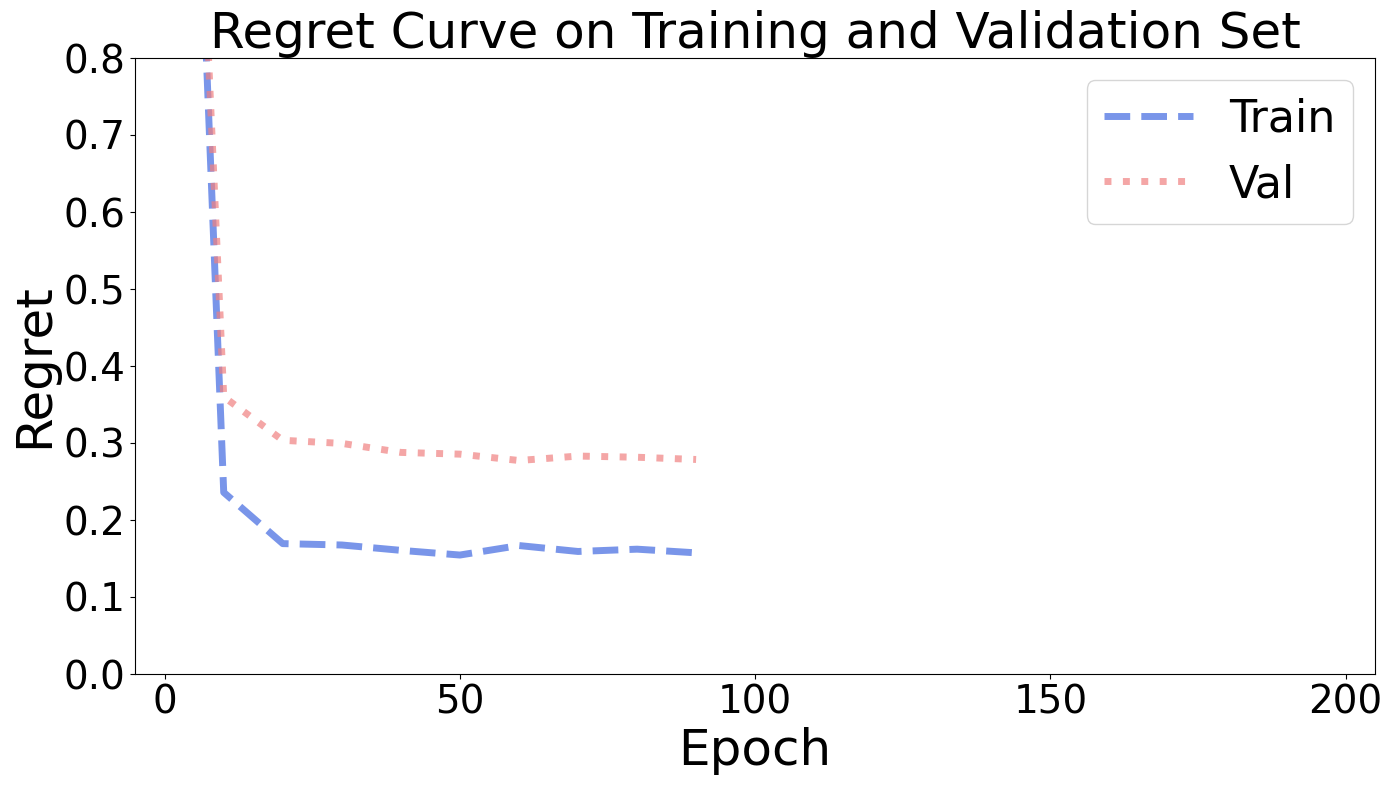

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)